In [121]:
# Importation des bibliothèques nécessaires
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from torchsummary import summary  # Permet d'afficher un résumé du modèle PyTorch

# Ce code importe les bibliothèques essentielles pour la manipulation des images,
# l'utilisation de modèles pré-entraînés et la visualisation des résultats.



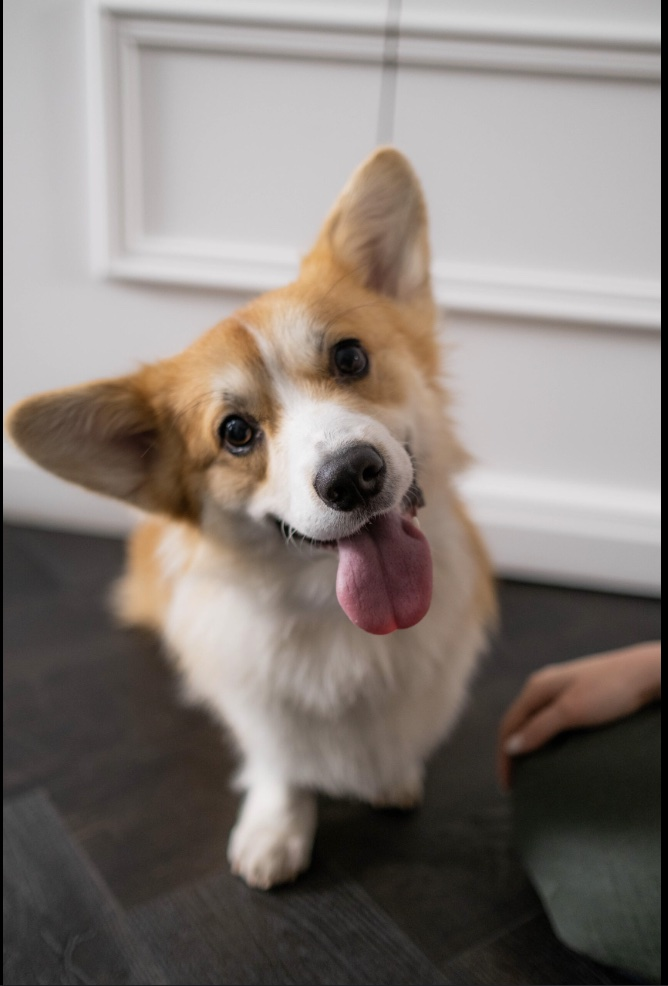

In [122]:
def preprocess_image(image_path):
    """
    Prétraitement d'une image avant de l'utiliser avec un modèle pré-entraîné.

    Paramètre:
    - image_path (str): Chemin de l'image à charger et prétraiter.

    Retour:
    - image (torch.Tensor): Image prétraitée sous forme de tenseur PyTorch.
    """

    # Définition des transformations à appliquer sur l'image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Redimensionnement de l'image à 224x224 pixels
        transforms.ToTensor(),  # Conversion de l'image en tenseur PyTorch (valeurs entre 0 et 1)
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # Normalisation pour correspondre aux statistiques d'ImageNet
    ])

    # Chargement de l'image avec PIL
    image = Image.open(image_path)
    display(image)  # Affichage de l'image originale pour vérification

    # Application des transformations et ajout d'une dimension batch (1, C, H, W)
    image = transform(image).unsqueeze(0)

    return image  # Retourne l'image sous forme de tenseur PyTorch

# Chemin de l'image à prétraiter
image_path = "/data/dog.jpg"

# Appel de la fonction pour prétraiter l'image
image_tensor = preprocess_image(image_path)


In [123]:
# Chargement du modèle pré-entraîné

# Option 1 : Utilisation de ResNet-50
# model = models.resnet50(pretrained=True)

# Option 2 : Utilisation d'EfficientNet-B0 (meilleur pour certaines tâches de classification)
model = models.efficientnet_b0(pretrained=True)  # Chargement du modèle pré-entraîné
print(model)  # Affichage de l'architecture du modèle

# Définition de l'appareil (GPU si disponible, sinon CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transfert du modèle vers l'appareil sélectionné (GPU ou CPU)
model.to(device)

# Transfert de l'image prétraitée vers le même appareil
image_tensor = image_tensor.to(device)



EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [124]:
def make_gradcam_heatmap(image_tensor, model, prediction_rank=1):
    """
    Génère une heatmap Grad-CAM pour visualiser les régions importantes de l'image.

    Paramètres :
    - image_tensor (torch.Tensor) : Image prétraitée sous forme de tenseur.
    - model (torch.nn.Module) : Modèle de classification d'images.
    - prediction_rank (int) : Classe à visualiser (1 pour la classe prédite principale).

    Retour :
    - cam (numpy.ndarray) : Heatmap normalisée Grad-CAM.
    - pred_index (int) : Index de la classe prédite.
    """

    # Met le modèle en mode évaluation
    model.eval()

    # Déclaration des variables pour stocker les activations et les gradients
    feature_map = None
    gradients = None

    # Fonction hook pour enregistrer la feature map de la dernière couche de convolution
    def save_feature_map(module, input, output):
        nonlocal feature_map
        feature_map = output

    # Fonction hook pour enregistrer le gradient de la dernière couche de convolution
    def save_gradient(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    # Sélection de la dernière couche de convolution du modèle
    #last_conv_layer = last_conv_layer = model.layer4[2].conv3  # Resnet50 : dernière couche convolutive
    last_conv_layer = model.features[-1]  # EfficientNet-B0 : dernière couche convolutive

    # Enregistrement des hooks
    last_conv_layer.register_forward_hook(save_feature_map)  # Hook pour les activations
    last_conv_layer.register_backward_hook(save_gradient)  # Hook pour les gradients

    # Exécution du forward pass et récupération de la prédiction
    output = model(image_tensor)
    pred_index = torch.argmax(output, dim=1)[0]

    # Rétropropagation pour calculer les gradients de la classe prédite
    model.zero_grad()
    output[:, pred_index].backward()  # Calcul des gradients de la classe prédite

    # Récupération des activations de la dernière couche convolutive
    activations = feature_map.detach()

    # Calcul des poids en moyennant les gradients sur les dimensions spatiales (H x W)
    weights = gradients.mean(dim=[2, 3], keepdim=True)

    # Création de la heatmap Grad-CAM
    cam = (weights * activations).sum(dim=1, keepdim=True)
    cam = F.relu(cam)  # Application de ReLU pour ne garder que les valeurs positives
    cam = cam.squeeze().cpu().numpy()

    # Normalisation de la heatmap dans l'intervalle [0,1]
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-7)

    return cam, pred_index.item()


Top 1 Prediction: Class 731, Probability 0.0027


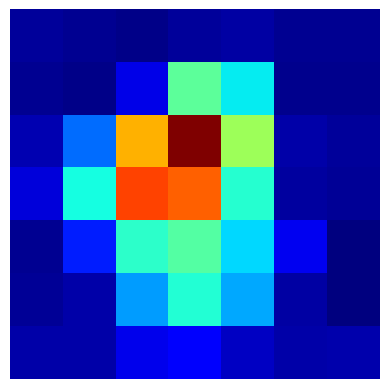

Predicted class: 263


In [125]:
with torch.no_grad():
    preds = model(image_tensor)
    probs = F.softmax(preds, dim=1)

# Récupération de la meilleure prédiction (classe avec la plus haute probabilité)
top1_prob, top1_class = torch.max(probs, dim=1)
print(f"Top 1 Prediction: Class {top1_class.item()}, Probability {top1_prob.item():.4f}")

# Génération de la heatmap Grad-CAM
heatmap, pred_class = make_gradcam_heatmap(image_tensor, model)

# Affichage de la heatmap
plt.imshow(heatmap, cmap='jet')  # Affiche la heatmap avec une colormap 'jet'
plt.axis('off')
plt.show()

print(f"Predicted class: {pred_class}")


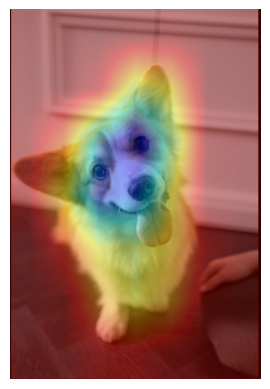

'gradcam_result.jpg'

In [126]:
def overlay_gradcam(img_path, heatmap, alpha=0.4, save_path="gradcam_result.jpg"):
    """
    Superpose la heatmap Grad-CAM sur l'image d'origine avec OpenCV.

    Paramètres :
    - img_path (str) : Chemin de l'image d'origine.
    - heatmap (numpy.ndarray) : Heatmap normalisée (valeurs entre 0 et 1).
    - alpha (float) : Opacité de la heatmap (par défaut 0.4, 0 = invisible, 1 = opaque).
    - save_path (str) : Chemin pour enregistrer l'image résultante.

    Retour :
    - save_path (str) : Chemin de l'image superposée enregistrée.
    """

    # Chargement de l'image d'origine
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertit BGR → RGB pour un affichage correct

    # Redimensionnement de la heatmap pour correspondre à la taille de l'image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Conversion de la heatmap en couleur avec la colormap JET
    heatmap = np.uint8(255 * heatmap)  # Mise à l'échelle [0, 255] pour l'affichage OpenCV
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Applique un colormap coloré

    # Superposition de la heatmap colorée sur l'image originale
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Enregistrement de l'image finale
    cv2.imwrite(save_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))

    # Affichage de l'image superposée
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()

    return save_path

overlay_gradcam(image_path, heatmap)
